# Spacenet Models

In [1]:
import numpy as np
import joblib as jlb
ims = jlb.load('../data/spacenet_datasets/ims.np')
mas = jlb.load('../data/spacenet_datasets/mas.np')
print(ims.shape)
print(mas.shape)

(1260, 1024, 1024, 4)
(1260, 1024, 1024)


### Exploratory Data Analysis

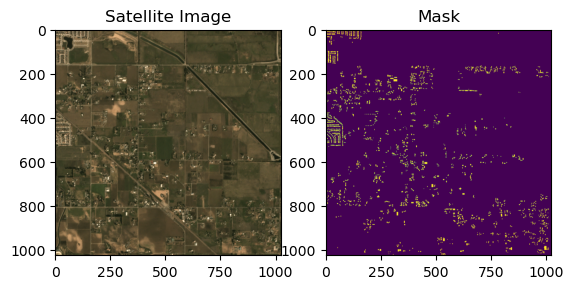

In [2]:
import matplotlib.pyplot as plt

# Show one image + its mask
idx = 0
plt.subplot(1,2,1)
plt.imshow(ims[idx])
plt.title("Satellite Image")

plt.subplot(1,2,2)
plt.imshow(mas[idx])
plt.title("Mask")
plt.show()

In [13]:
import cv2
import os
import glob

# Input folders
img_dir = "../data/spacenet_datasets/images/"
mask_dir = "../data/spacenet_datasets/masks/"

# Output folders
out_img_dir = "../data/spacenet_datasets/preprocessed/images/"
out_mask_dir = "../data/spacenet_datasets/preprocessed/masks/"
os.makedirs(out_img_dir, exist_ok=True)
os.makedirs(out_mask_dir, exist_ok=True)

# Target size
TARGET_SIZE = (256, 256)   # (W,H)

# Get sorted file lists
img_files = sorted(glob.glob(img_dir + "*.png"))
mask_files = sorted(glob.glob(mask_dir + "*.png"))

print(f"Found {len(img_files)} images and {len(mask_files)} masks")

for i, (img_path, mask_path) in enumerate(zip(img_files, mask_files)):
    # Load image & mask
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize
    img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
    
    # Save to new folder
    out_img_path = os.path.join(out_img_dir, f"{i+1:05d}.png")
    out_mask_path = os.path.join(out_mask_dir, f"{i+1:05d}.png")
    
    cv2.imwrite(out_img_path, img_resized)
    cv2.imwrite(out_mask_path, mask_resized)

print("✅ Resizing complete. Preprocessed dataset stored in spacenet/preprocessed/")

Found 1260 images and 1260 masks
✅ Resizing complete. Preprocessed dataset stored in spacenet/preprocessed/


🔹 Original RGB pixels [Top-left 5x5 block]:
[[[ 82  75  47]
  [161 135 104]
  [177 152 121]
  [180 152 116]
  [166 141 109]]

 [[123 106  77]
  [128 116  83]
  [134 114  84]
  [205 171 138]
  [177 150 119]]

 [[128 107  80]
  [135 115  87]
  [135 116  83]
  [195 164 131]
  [166 139 108]]

 [[133 109  82]
  [143 119  91]
  [150 127  95]
  [158 131 101]
  [178 149 115]]

 [[129 105  78]
  [135 111  81]
  [172 145 116]
  [153 128  97]
  [192 159 128]]]

🔹 Grayscale pixels [Top-left 5x5 block]:
[[ 74 139 156 156 145]
 [108 116 117 177 155]
 [110 118 118 170 144]
 [113 123 130 136 154]
 [109 115 150 132 165]]

📊 Grayscale Summary:
Min: 6, Max: 254, Mean: 102.47


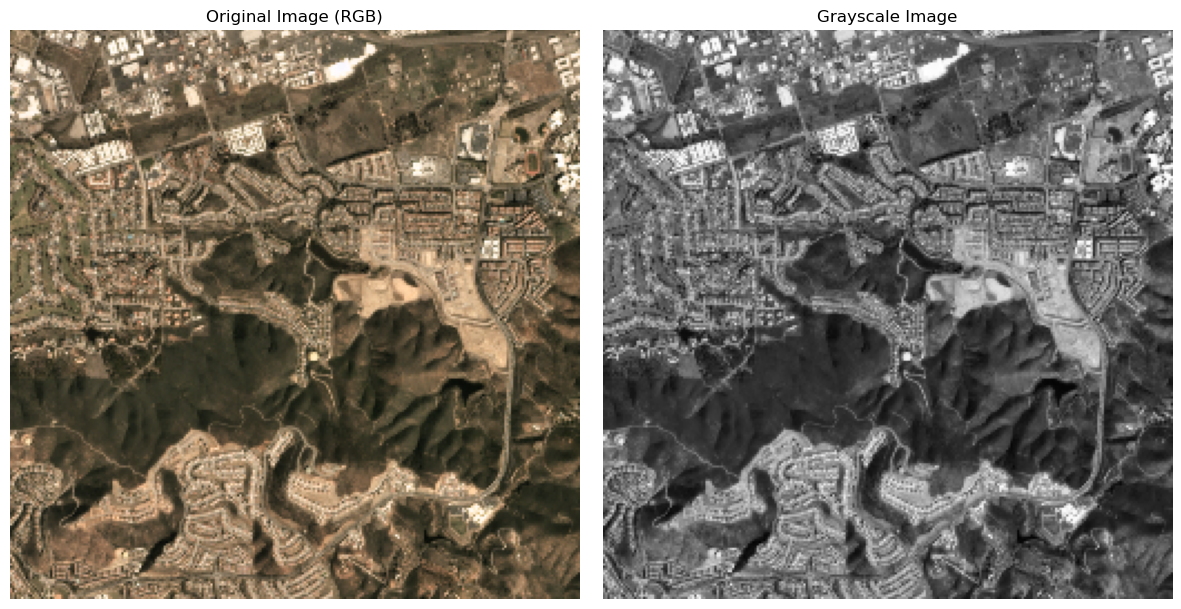

In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# 🔹 Load one sample image
# ==============================
img_path = "../data/spacenet_datasets/preprocessed/images/00028.png"

# Read image using OpenCV (BGR format)
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError(f"❌ Could not load image: {img_path}")

# Convert to RGB for correct color display in Matplotlib
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Convert to Grayscale
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# ==============================
# 🧮 Print pixel information
# ==============================
print("🔹 Original RGB pixels [Top-left 5x5 block]:")
print(img_rgb[:5, :5, :])   # Each pixel has (R,G,B)

print("\n🔹 Grayscale pixels [Top-left 5x5 block]:")
print(gray[:5, :5])         # Each pixel has 1 intensity value

print("\n📊 Grayscale Summary:")
print(f"Min: {gray.min()}, Max: {gray.max()}, Mean: {gray.mean():.2f}")

# ==============================
# 🎨 Display both images side by side
# ==============================
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image (RGB)")
plt.imshow(img_rgb)
plt.axis("off")

# Grayscale image
plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(gray, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import glob
import numpy as np
import shutil

# ===============================
# 📁 Paths
# ===============================
image_dir = "../data/spacenet_datasets/preprocessed/images/"
mask_dir = "../data/spacenet_datasets/preprocessed/masks/"
bad_dir = "../data/spacenet_datasets/bad_samples/"

os.makedirs(bad_dir, exist_ok=True)

# ===============================
# 🧰 Helper function to move bad files
# ===============================
def move_bad_file(src_path, dest_folder):
    if os.path.exists(src_path):
        dest_path = os.path.join(dest_folder, os.path.basename(src_path))
        if os.path.exists(dest_path):
            os.remove(dest_path)  # overwrite safely
        shutil.move(src_path, dest_path)

# ===============================
# 🧪 Check for black image ratio
# ===============================
def is_black_image(img, threshold_ratio=0.1, pixel_threshold=15):
    """Return True if the ratio of 'dark' pixels is higher than threshold_ratio."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    total_pixels = gray.size
    black_pixels = np.sum(gray <= pixel_threshold)  # dark pixels
    black_ratio = black_pixels / total_pixels
    return black_ratio >= threshold_ratio

# ===============================
# 🧹 Main cleanup loop
# ===============================
bad_count = 0
img_files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
for img_path in img_files:
    fname = os.path.basename(img_path)
    mask_path = os.path.join(mask_dir, fname)

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not load image: {fname}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    black_ratio = np.sum(gray <= 40) / gray.size

    if black_ratio > 0.1:
        print(f"🗑 Removing {fname} (black_ratio={black_ratio:.2f})")
        move_bad_file(img_path, bad_dir)
        move_bad_file(mask_path, bad_dir)
        bad_count += 1
    else:
        print(f"✅ Keeping {fname} (black_ratio={black_ratio:.2f})")

print(f"\n✅ Cleanup complete. {bad_count} black/partial black samples moved to bad_samples/")


✅ Keeping 00001.png (black_ratio=0.01)
✅ Keeping 00002.png (black_ratio=0.01)
✅ Keeping 00003.png (black_ratio=0.01)
✅ Keeping 00004.png (black_ratio=0.02)
✅ Keeping 00005.png (black_ratio=0.00)
✅ Keeping 00006.png (black_ratio=0.00)
✅ Keeping 00007.png (black_ratio=0.00)
✅ Keeping 00008.png (black_ratio=0.00)
✅ Keeping 00009.png (black_ratio=0.00)
✅ Keeping 00010.png (black_ratio=0.01)
✅ Keeping 00011.png (black_ratio=0.01)
🗑 Removing 00012.png (black_ratio=0.06)
🗑 Removing 00013.png (black_ratio=0.08)
✅ Keeping 00014.png (black_ratio=0.04)
🗑 Removing 00015.png (black_ratio=0.11)
✅ Keeping 00016.png (black_ratio=0.04)
🗑 Removing 00017.png (black_ratio=0.05)
✅ Keeping 00018.png (black_ratio=0.01)
✅ Keeping 00019.png (black_ratio=0.00)
✅ Keeping 00020.png (black_ratio=0.01)
✅ Keeping 00021.png (black_ratio=0.00)
✅ Keeping 00022.png (black_ratio=0.01)
✅ Keeping 00023.png (black_ratio=0.02)
✅ Keeping 00024.png (black_ratio=0.04)
🗑 Removing 00025.png (black_ratio=0.06)
🗑 Removing 00026.png

In [16]:
import os
import cv2
import numpy as np
from glob import glob

# Directories
img_dir = "../data/spacenet_datasets/preprocessed/images/"
mask_dir = "../data/spacenet_datasets/preprocessed/masks/"
bad_dir = "../data/spacenet_datasets/bad_samples/"  # optional

# Create backup folder if you want to move bad samples
os.makedirs(bad_dir, exist_ok=True)

bad_images = []

import os
import shutil

def move_bad_file(src_path, dest_folder):
    """Move bad file to a backup folder safely, overwriting if exists."""
    if os.path.exists(src_path):
        dest_path = os.path.join(dest_folder, os.path.basename(src_path))
        if os.path.exists(dest_path):
            os.remove(dest_path)  # remove existing file
        shutil.move(src_path, dest_path)

for img_path in glob(os.path.join(img_dir, "*.png")):
    fname = os.path.basename(img_path)
    mask_path = os.path.join(mask_dir, fname)

    # 1️⃣ Mask missing
    if not os.path.exists(mask_path):
        bad_images.append(fname)
        move_bad_file(img_path, bad_dir)
        continue

    # 2️⃣ Load image & mask
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

    if img is None or mask is None:
        bad_images.append(fname)
        move_bad_file(img_path, bad_dir)
        move_bad_file(mask_path, bad_dir)
        continue

    # 3️⃣ Size mismatch
    if img.shape[:2] != mask.shape[:2]:
        bad_images.append(fname)
        move_bad_file(img_path, bad_dir)
        move_bad_file(mask_path, bad_dir)
        continue

    # 4️⃣ Fully black image or mask
    if np.all(img == 0) or np.all(mask == 0):
        bad_images.append(fname)
        move_bad_file(img_path, bad_dir)
        move_bad_file(mask_path, bad_dir)
        continue


print(f"🧾 Bad images found: {len(bad_images)}")
print("Examples:", bad_images[:10])
print("✅ Moved all bad samples to:", bad_dir)


🧾 Bad images found: 15
Examples: ['00179.png', '00188.png', '00189.png', '00192.png', '01238.png', '01239.png', '01240.png', '01241.png', '01242.png', '01243.png']
✅ Moved all bad samples to: ../data/spacenet_datasets/bad_samples/


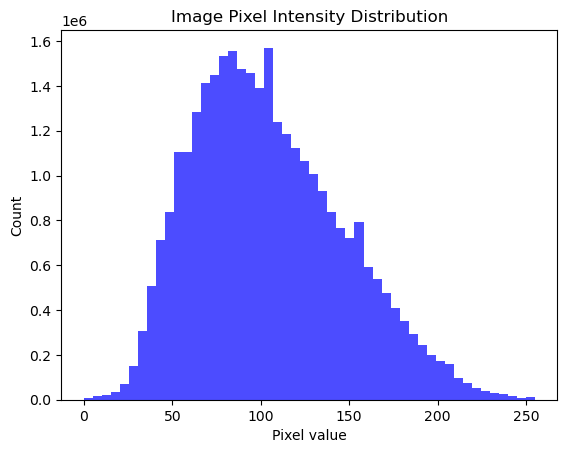

In [4]:
import matplotlib.pyplot as plt
import cv2
import glob
img_files = sorted(glob.glob("../data/spacenet_datasets/images/*.png"))
# Flatten all pixel values (use first 50 images for speed)
pixels = []
for f in img_files[:10]:
    img = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    pixels.extend(img.flatten())

plt.hist(pixels, bins=50, color='blue', alpha=0.7)
plt.title("Image Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Count")
plt.show()

Unique mask values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 24

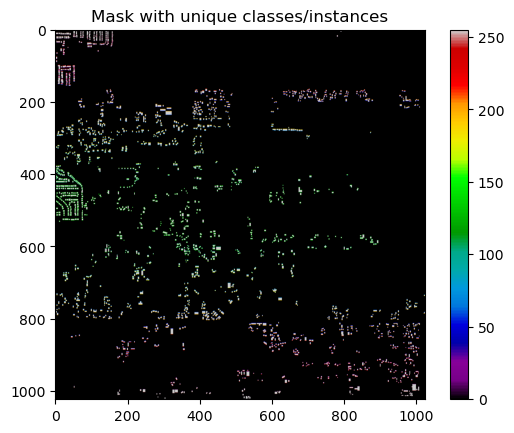

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Example: load one mask
mask = cv2.imread("../data/spacenet_datasets/masks/00001.png", cv2.IMREAD_UNCHANGED)

# Get unique values
unique_vals = np.unique(mask)
print("Unique mask values:", unique_vals)
print("Number of unique values:", len(unique_vals))

# Visualize mask
plt.imshow(mask, cmap="nipy_spectral")  # better colormap for classes
plt.colorbar()
plt.title("Mask with unique classes/instances")
plt.show()

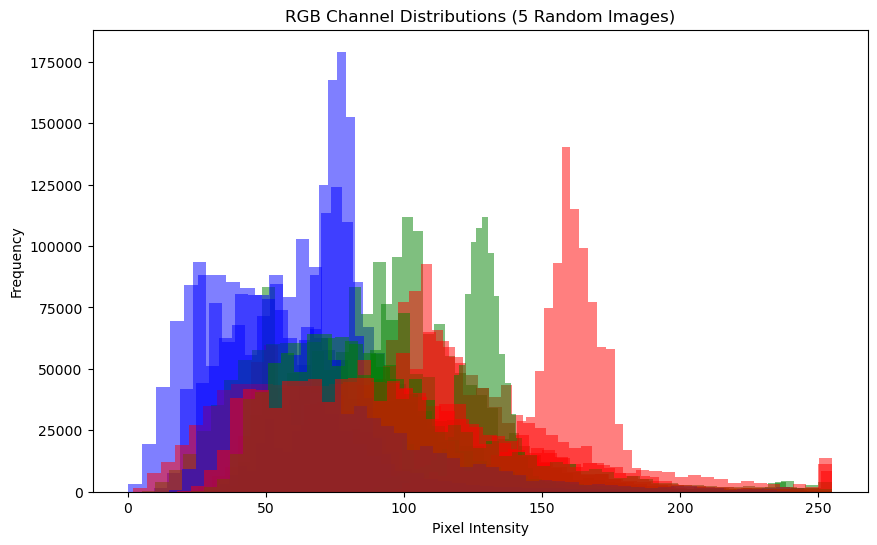

In [6]:
import cv2
import glob
import random
import matplotlib.pyplot as plt
import numpy as np

# Get image list
img_files = sorted(glob.glob("../data/spacenet_datasets/images/*.png"))

# Pick 5 random images
sample_files = random.sample(img_files, 5)

plt.figure(figsize=(10,6))
colors = ('b','g','r')

for f in sample_files:
    img = cv2.imread(f)
    for i, col in enumerate(colors):
        plt.hist(img[:,:,i].ravel(), bins=50, color=col, alpha=0.5)  # transparent overlay

plt.title("RGB Channel Distributions (5 Random Images)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


### Data Preprocessing

In [7]:
import glob
import cv2
import numpy as np

img_dir = "../data/spacenet_datasets/preprocessed/images/"
mask_dir = "../data/spacenet_datasets/preprocessed/masks/"

img_files = sorted(glob.glob(img_dir + "*.png"))
mask_files = sorted(glob.glob(mask_dir + "*.png"))

print(f"Total Images: {len(img_files)}")
print(f"Total Masks:  {len(mask_files)}")

# Check shape + channels of one sample
sample_img = cv2.imread(img_files[0], cv2.IMREAD_UNCHANGED)
sample_mask = cv2.imread(mask_files[0], cv2.IMREAD_GRAYSCALE)

print("Image shape:", sample_img.shape)
print("Mask shape:", sample_mask.shape)
print("Image dtype:", sample_img.dtype, "| Mask dtype:", sample_mask.dtype)


Total Images: 1260
Total Masks:  1260
Image shape: (256, 256, 3)
Mask shape: (256, 256)
Image dtype: uint8 | Mask dtype: uint8


In [8]:
import cv2
import numpy as np
import os

mask_path = "../data/spacenet_datasets/masks/00001.png"
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

# Convert to binary
binary_mask = (mask > 0).astype("uint8")

# Save to preprocessed folder
out_path = "../data/processed/spacenet/masks_binary/00001.png"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
cv2.imwrite(out_path, binary_mask * 255)  # save as black & white image


True

In [9]:
# Example: load one mask
mask = cv2.imread("../data/spacenet_datasets/preprocessed/masks/00001.png", cv2.IMREAD_UNCHANGED)

# Get unique values
unique_vals = np.unique(mask)
print("Unique mask values:", unique_vals)
print("Number of unique values:", len(unique_vals))

Unique mask values: [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  42  43  44  45  46  47  48  49  50  51  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  88  89  90  91  92  93  94  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 118 119 120 121 122 123 124 125 127 129 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170 171 172 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 217 218 219 220 221 222 223 224 225 226 227 228 230 231 232
 235 236 238 239 240 241 242 243 244 245 247 248 249 250 251 252 253 254
 255]
Number of unique values: 

In [10]:
import cv2

# Load example image + mask
img = cv2.imread("../data/spacenet_datasets/images/00001.png", cv2.IMREAD_UNCHANGED)
mask = cv2.imread("../data/spacenet_datasets/masks/00001.png", cv2.IMREAD_GRAYSCALE)

print("Original shapes:", img.shape, mask.shape)

# ✅ Resize to 256x256 (or 512x512 if GPU allows)
img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)
mask_resized = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

print("Resized shapes:", img_resized.shape, mask_resized.shape)


Original shapes: (1024, 1024, 3) (1024, 1024)
Resized shapes: (256, 256, 3) (256, 256)


In [11]:
# Convert to float32 and normalize [0,1]
img_norm = img_resized.astype("float32") / 255.0
print(img_norm[0, :5, :])  # Print first 5 values of first row for verification

[[0.73333335 0.78431374 0.8509804 ]
 [0.34901962 0.4392157  0.4627451 ]
 [0.6666667  0.7764706  0.85882354]
 [0.47058824 0.57254905 0.61960787]
 [0.5921569  0.6784314  0.7490196 ]]


In [12]:
# Convert mask to integer values
mask_final = mask_resized.astype("int64")

# If binary, make sure values are 0 and 1
mask_final[mask_final > 0] = 1
mask_final

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(256, 256))

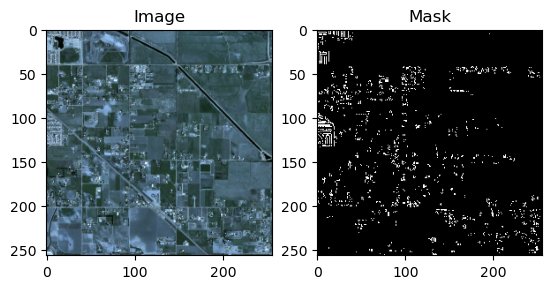

In [13]:
plt.subplot(1,2,1)
plt.imshow(img_norm)
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(mask_final, cmap="gray")
plt.title("Mask")
plt.show()


In [15]:
import pandas as pd
import glob

# Load all preprocessed images
img_files = sorted(glob.glob("../data/spacenet_datasets/preprocessed/images/*.png"))
mask_files = sorted(glob.glob("../data/spacenet_datasets/preprocessed/masks/*.png"))

means, stds, mins, maxs = [], [], [], []
for i in range(0,len(img_files),50):
    for img_path in img_files[i:i+50]:
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        means.append(img.mean())
        stds.append(img.std())
        mins.append(img.min())
        maxs.append(img.max())

df = pd.DataFrame({
    "mean": means,
    "std": stds,
    "min": mins,
    "max": maxs
})

print(df.describe())


              mean          std          min          max
count  1260.000000  1260.000000  1260.000000  1260.000000
mean     96.240658    39.296392    16.469841   251.490476
std      37.641176     9.830497    24.925526    27.863318
min       0.000000     0.000000     0.000000     0.000000
25%      72.027196    33.144037     0.000000   255.000000
50%      87.567116    38.777166     5.000000   255.000000
75%     112.638273    45.640145    23.000000   255.000000
max     208.692403    70.913548   145.000000   255.000000


In [17]:
import os
import glob
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
img_dir = "../data/spacenet_datasets/preprocessed/images/"
mask_dir = "../data/spacenet_datasets/preprocessed/masks/"
out_dir = "../data/spacenet_datasets/split/"

# Create output directories
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(out_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(out_dir, split, "masks"), exist_ok=True)

# Get file list
img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))
mask_files = [os.path.join(mask_dir, os.path.basename(f)) for f in img_files]

# Split into train/val/test
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    img_files, mask_files, test_size=0.2, random_state=42
)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    test_imgs, test_masks, test_size=0.5, random_state=42
)

def copy_files(img_list, mask_list, split_name):
    for img_path, mask_path in zip(img_list, mask_list):
        shutil.copy(img_path, os.path.join(out_dir, split_name, "images", os.path.basename(img_path)))
        shutil.copy(mask_path, os.path.join(out_dir, split_name, "masks", os.path.basename(mask_path)))

copy_files(train_imgs, train_masks, "train")
copy_files(val_imgs, val_masks, "val")
copy_files(test_imgs, test_masks, "test")

print(f"✅ Split complete:\nTrain: {len(train_imgs)}\nVal: {len(val_imgs)}\nTest: {len(test_imgs)}")


✅ Split complete:
Train: 996
Val: 124
Test: 125


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# =========================================
# Paths to your images, masks, and model
# =========================================
IMAGE_DIR = r"../data/spacenet_datasets/preprocessed/images"   # change if needed
MASK_DIR  = r"../data/spacenet_datasets/preprocessed/masks"    # change if needed
MODEL_PATH = "final_unet_model.h5"   # or final_unet_model.h5

IMG_SIZE = (256, 256)

# -----------------------------------------
# Helper Functions
# -----------------------------------------
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0
    return img

def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE)
    mask = (mask > 127).astype(np.float32)
    return mask

# -----------------------------------------
# Load data file names
# -----------------------------------------
image_files = sorted(os.listdir(IMAGE_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

# Pick any 2 samples (you can choose specific indexes if needed)
sample_indices = [10, 50]   # change numbers to view different samples

# -----------------------------------------
# Load Model
# -----------------------------------------
print("Loading model...")
model = load_model(MODEL_PATH, compile=False)

# -----------------------------------------
# Visualization Loop
# -----------------------------------------
for idx in sample_indices:
    img_path = os.path.join(IMAGE_DIR, image_files[idx])
    mask_path = os.path.join(MASK_DIR, mask_files[idx])

    img = load_image(img_path)
    true_mask = load_mask(mask_path)
    pred_mask = model.predict(np.expand_dims(img, axis=0))[0].squeeze()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Satellite Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# =========================================
# USER SETTINGS
# =========================================
MODEL_PATH = "/content/final_unet_model.h5"  # <- Change if needed
IMG_SIZE = (256, 256)

# Load Segmentation Model
print("Loading segmentation model...")
model = load_model(MODEL_PATH, compile=False)


# =========================================
# Helper Functions
# =========================================
def load_image_array(img_array):
    img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0
    return img

def analyze_mask(mask):
    mask = (mask > 0.5).astype(np.uint8)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    areas = stats[1:, cv2.CC_STAT_AREA]
    
    building_count = len(areas)
    avg_building_size = np.mean(areas) if building_count > 0 else 0
    total_building_area = np.sum(areas)

    return building_count, avg_building_size, total_building_area

def classify_area(building_count, avg_building_size):
    if building_count < 20 and avg_building_size > 1500:
        return "Commercial"
    else:
        return "Residential"


# =========================================
# FILE UPLOAD
# =========================================
print("📤 Please upload a satellite image...")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
input_img = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)
img = load_image_array(input_img)

# Predict mask
pred_mask = model.predict(np.expand_dims(img, axis=0))[0].squeeze()

# Analyze buildings
building_count, avg_size, total_area = analyze_mask(pred_mask)
classification = classify_area(building_count, avg_size)


# =========================================
# DISPLAY RESULTS
# =========================================
print("\n===== AREA ANALYSIS RESULT =====")
print("🧱 Buildings Detected:", building_count)
print("📏 Avg Building Size:", round(avg_size, 2))
print("🌍 Land Use Classification:", classification)

# Visualize
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Satellite Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Building Mask")
plt.axis("off")
plt.show()


In [1]:
import pandas as pd

# Load your file
df = pd.read_excel("bharatfakenewskosh.xlsx")

# Check unique values to confirm language codes
print(df['Language'].unique())

# Remove English rows
df = df[df['Language'].str.lower() != 'English']

# Reset index (optional)
df = df.reset_index(drop=True)

print("Remaining rows:", len(df))

# Save filtered file
df.to_excel("bharatfakenewskosh_filtered.xlsx", index=False)
print("Saved to bharatfakenewskosh_filtered.xlsx")


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.